In [1]:
# https://www.kaggle.com/hhyun2/hubmap-pytorch-gpu-training/comments

import sys
import os
sys.path.append(os.path.join(str(os.path.abspath('')), "..", ".."))

from src.utils.losses import DiceLoss, DiceBCELoss
from src.utils.dice_coef import DiceCoef
from src.utils.set_seed import seed_torch
from src.utils.transforms import get_transform

from sklearn.model_selection import GroupKFold
import torch
from torch import nn
import torchvision
import cv2
import os
import numpy as np
import pandas as pd
from torchvision import transforms
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau, CosineAnnealingWarmRestarts
from scipy.ndimage.interpolation import zoom
import albumentations as A
from torch.nn import functional as F
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt
import sys
import time
import random

import segmentation_models_pytorch as smp
from segmentation_models_pytorch import Unet, FPN, UnetPlusPlus

In [2]:
class CFG:
    data = 512 #256
    debug=False
    apex=False
    print_freq=100
    num_workers=4
    img_size=512 # appropriate input size for encoder 
    epoch=20 # Change epochs
    criterion= 'DiceBCELoss' #'DiceBCELoss' # ['DiceLoss', 'Hausdorff', 'Lovasz']
    lr=1e-4
    min_lr=1e-6
    batch_size=14
    weight_decay=1e-5
    seed=2021
    n_fold=5
    trn_fold=[0, 1, 2, 3, 4]
    train=True
    inference=False
    optimizer = 'Adam'
    T_0=10
    # N=5 
    # M=9
    T_max=10
    factor=0.1
    patience=4
    eps=1e-8
    smoothing=1
    train_transform_type = 'strong'
    valid_transform_type = 'val'

In [3]:
# TEST_IMAGES = ['b9a3865fc', '2f6ecfcdf', '26dc41664']
seed_torch(seed=CFG.seed)
train_transform = get_transform(img_size=CFG.img_size, transform_type=CFG.train_transform_type)
valid_transform = get_transform(img_size=CFG.img_size, transform_type=CFG.valid_transform_type)
RESIZED_DATA_DIR = 'HERE_DEFINE_PATH_TO_RESIZED_TILES/'
PATH_TO_KAGGLE_INPUT = 'HERE_DEFINE_PATH_TO_KAGGLE_INPUT/'

In [4]:
class HuBMAPDataset(Dataset):
    def __init__(self,df, train='train', transform=True):
        ids = df.id.values
        #kf = KFold(n_splits=nfolds,random_state=SEED,shuffle=True)
        #ids = set(ids[list(kf.split(ids))[fold][0 if train else 1]])
        if CFG.data==1024:
            self.fnames = [fname for fname in os.listdir(RESIZED_DATA_DIR + '1024*1024/train/') if fname.split('_')[0] in ids]
        elif CFG.data==512:
            self.fnames = [fname for fname in os.listdir(RESIZED_DATA_DIR + '512*512/train/') if fname.split('_')[0] in ids]
        elif CFG.data==256:
            self.fnames = [fname for fname in os.listdir(RESIZED_DATA_DIR + '256*256/train/') if fname.split('_')[0] in ids]
        self.train = train
        self.transform = transform
        
    def __len__(self):
        return len(self.fnames)
    
    def __getitem__(self, idx):
        fname = self.fnames[idx]
        if CFG.data==1024:
            img = cv2.cvtColor(cv2.imread(os.path.join(RESIZED_DATA_DIR + '1024*1024/train/',fname)), cv2.COLOR_BGR2RGB)
            mask = cv2.imread(os.path.join(RESIZED_DATA_DIR + '1024*1024/masks',fname),cv2.IMREAD_GRAYSCALE)
        elif CFG.data==512:
            img = cv2.cvtColor(cv2.imread(os.path.join(RESIZED_DATA_DIR + '512*512/train/',fname)), cv2.COLOR_BGR2RGB)
            mask = cv2.imread(os.path.join(RESIZED_DATA_DIR + '512*512/masks',fname),cv2.IMREAD_GRAYSCALE)
        elif CFG.data==256:
            img = cv2.cvtColor(cv2.imread(os.path.join(RESIZED_DATA_DIR + '256*256/train/',fname)), cv2.COLOR_BGR2RGB)
            mask = cv2.imread(os.path.join(RESIZED_DATA_DIR + '256*256/masks',fname),cv2.IMREAD_GRAYSCALE)
        
        if self.train == 'train':
            if self.transform == True:
                augmented = train_transform(image=img,mask=mask)
                img,mask = augmented['image'],augmented['mask']
                    
        elif self.train == 'val':
            transformed = valid_transform(image=img,mask=mask)
            img,mask = transformed['image'],transformed['mask']
            
        img = img.type('torch.FloatTensor')
        img = img/255
        mask = mask.type('torch.FloatTensor')

        return img, mask
          


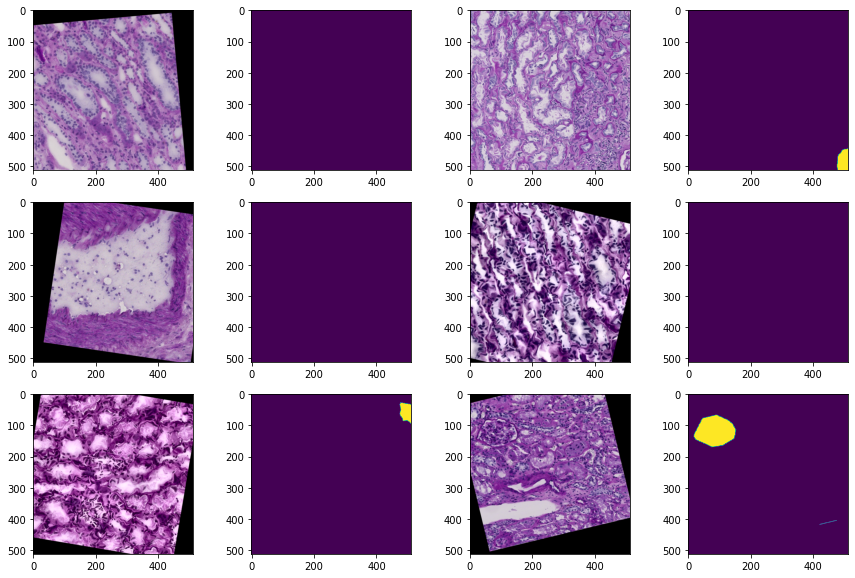

In [5]:
train_df = pd.read_csv(PATH_TO_KAGGLE_INPUT + 'train.csv')
# weak augmentation
train_dataset = HuBMAPDataset(train_df, train='train', transform=True)
plt.figure(figsize=(15,10))
for i in range(6):
    image, mask = train_dataset[i]
    plt.subplot(3,4,2*i+1)
    plt.imshow(np.transpose((image), (1,2,0)))
    plt.subplot(3,4,2*i+2)
    plt.imshow(mask)

In [6]:
if CFG.data==1024:
    directory_list = os.listdir(RESIZED_DATA_DIR + '1024*1024/train')
elif CFG.data==512:
    directory_list = os.listdir(RESIZED_DATA_DIR + '512*512/train')
elif CFG.data==256:
    directory_list = os.listdir(RESIZED_DATA_DIR + '256*256/train')
directory_list = [fnames.split('_')[0] for fnames in directory_list]
dir_df = pd.DataFrame(directory_list, columns=['id'])
dir_df

,id
0,afa5e8098
1,0486052bb
2,afa5e8098
3,afa5e8098
4,095bf7a1f
...,...
9579,b2dc8411c
9580,c68fe75ea
9581,095bf7a1f
9582,095bf7a1f


In [7]:
if CFG.criterion == 'DiceBCELoss':
    criterion = DiceBCELoss()
elif CFG.criterion == 'DiceLoss':
    criterion = DiceLoss()
elif CFG.criterion == 'Hausdorff':
    criterion = Hausdorff_loss()
elif CFG.criterion == 'Lovasz':
    criterion = Lovasz_loss()

In [8]:
def HuBMAPLoss(images, targets, model, device, loss_func=criterion):
    model.to(device)
    images = images.to(device)
    targets = targets.to(device)
    outputs = model(images)
    loss_func = loss_func
    loss = loss_func(outputs, targets)
    return loss, outputs

def HuBMAPMetric(outputs, targets):
#     model.to(device)
#     images = images.to(device)
#     targets = targets.to(device)
#     outputs = model(images)
    criterion = DiceCoef()
    metric = criterion(outputs, targets)
    return metric

In [9]:
def train_one_epoch(epoch, model, device, optimizer, scheduler, trainloader):
    model.train()
    t = time.time()
    total_loss = 0
    total_metric = 0
    total_metric_new = 0
    for step, (images, targets) in enumerate(trainloader):
        loss, outputs = HuBMAPLoss(images, targets, model, device)
        loss.backward()
        if ((step+1)%4==0 or (step+1)==len(trainloader)):
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
        loss = loss.detach().item()
        total_loss += loss
#         print("ou:", outputs)
#         print("tar", targets)
        metric, metric_new = HuBMAPMetric(outputs.cpu(), targets)
        total_metric += metric
        total_metric_new += metric_new
        if ((step+1)%10==0 or (step+1)==len(trainloader)):
            print(
                    f'epoch {epoch} train step {step+1}/{len(trainloader)}, ' + \
                    f'loss: {total_loss/len(trainloader):.4f}, ' + \
                    f'dice_coef: {total_metric/len(trainloader):.4f}, ' + \
                    f'dice_coef_new: {total_metric_new/len(trainloader):.4f}, ' + \
                    f'time: {(time.time() - t):.4f}', end= '\r' if (step + 1) != len(trainloader) else '\n'
                )
        
        
def valid_one_epoch(epoch, model, device, optimizer, scheduler, validloader):
    model.eval()
    t = time.time()
    total_loss = 0
    total_metric = 0
    total_metric_new = 0
    for step, (images, targets) in enumerate(validloader):
        loss, outputs = HuBMAPLoss(images, targets, model, device)
        loss = loss.detach().item()
        total_loss += loss
        metric, metric_new = HuBMAPMetric(outputs.cpu(), targets)
        total_metric += metric
        total_metric_new += metric_new
        if ((step+1)%4==0 or (step+1)==len(validloader)):
            scheduler.step(total_loss/len(validloader))
        if ((step+1)%10==0 or (step+1)==len(validloader)):
            print(
                    f'epoch {epoch} valid step {step+1}/{len(validloader)}, ' + \
                    f'loss: {total_loss/len(validloader):.4f}, ' + \
                    f'dice_coef: {total_metric/len(validloader):.4f}, ' + \
                    f'dice_coef_new: {total_metric_new/len(validloader):.4f}, ' + \
                    f'time: {(time.time() - t):.4f}', end= '\r' if (step + 1) != len(validloader) else '\n'
                )

In [10]:
FOLDS = 5
gkf = GroupKFold(FOLDS)
dir_df['Folds'] = 0
for fold, (tr_idx, val_idx) in enumerate(gkf.split(dir_df, groups=dir_df[dir_df.columns[0]].values)):
    dir_df.loc[val_idx, 'Folds'] = fold

In [11]:
dir_df[dir_df['Folds'] == 4].id.unique()

array(['b9a3865fc', '2f6ecfcdf', '26dc41664'], dtype=object)

In [12]:
def prepare_train_valid_dataloader(df, fold):
    train_ids = df[~df.Folds.isin(fold)]
    val_ids = df[df.Folds.isin(fold)]
    
    train_ds = HuBMAPDataset(train_ids, train='train', transform=True)
    val_ds = HuBMAPDataset(val_ids, train='val', transform=True)
    train_loader = DataLoader(train_ds, batch_size=CFG.batch_size, pin_memory=True, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_ds, batch_size=CFG.batch_size, pin_memory=True, shuffle=False, num_workers=4)
    return train_loader, val_loader

In [13]:
class HuBMAP(nn.Module):
    def __init__(self):
        super(HuBMAP, self).__init__()
        self.cnn_model = smp.Unet('efficientnet-b4', encoder_weights="imagenet", classes=1)
        #self.cnn_model.decoder.blocks.append(self.cnn_model.decoder.blocks[-1])
        #self.cnn_model.decoder.blocks[-2] = self.cnn_model.decoder.blocks[-3]
    
    def forward(self, imgs):
        img_segs = self.cnn_model(imgs)
        return img_segs

In [14]:
for fold, (tr_idx, val_idx) in enumerate(gkf.split(dir_df, groups=dir_df[dir_df.columns[0]].values)):
    trainloader, validloader = prepare_train_valid_dataloader(dir_df, [fold])
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = HuBMAP().to(device)
    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, 
                     amsgrad=False
                    )
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
#         scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
#         scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
#         scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.1, step_size=1)

    num_epochs = CFG.epoch
    for epoch in range(num_epochs):
        train_one_epoch(epoch, model, device, optimizer, scheduler, trainloader)
        with torch.no_grad():
            valid_one_epoch(epoch, model, device, optimizer, scheduler, validloader)
    torch.save(model.state_dict(),f'weights/FOLD-{fold}-model.pth')

/home/greylord/hubmap_kidney/hubmap_venv/lib/python3.8/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch 0 train step 550/550, loss: 1.4386, dice_coef: 0.0966, dice_coef_new: 0.2724, time: 285.6457
epoch 0 valid step 135/135, loss: 1.1832, dice_coef: 0.1845, dice_coef_new: 0.6339, time: 20.0777
epoch 1 train step 550/550, loss: 1.1229, dice_coef: 0.1661, dice_coef_new: 0.7232, time: 291.5364
epoch 1 valid step 135/135, loss: 0.9807, dice_coef: 0.2503, dice_coef_new: 0.8626, time: 20.1939
epoch 2 train step 550/550, loss: 0.9934, dice_coef: 0.2122, dice_coef_new: 0.8338, time: 288.7722
epoch 2 valid step 135/135, loss: 0.8723, dice_coef: 0.3032, dice_coef_new: 0.8753, time: 20.2883
epoch 3 train step 550/550, loss: 0.8980, dice_coef: 0.2587, dice_coef_new: 0.8472, time: 292.2636
epoch 3 valid step 135/135, loss: 0.7740, dice_coef: 0.3581, dice_coef_new: 0.9038, time: 20.2478
epoch 4 train step 550/550, loss: 0.8098, dice_coef: 0.3103, dice_coef_new: 0.8579, time: 288.8446
epoch 4 valid step 135/135, loss: 0.6766, dice_coef: 0.4261, dice_coef_new: 0.8919, time: 20.3119
epoch 5 train s

epoch 2 train step 550/550, loss: 1.0254, dice_coef: 0.2034, dice_coef_new: 0.8357, time: 286.0686
epoch 2 valid step 135/135, loss: 0.9263, dice_coef: 0.2579, dice_coef_new: 0.9000, time: 20.1925
epoch 3 train step 550/550, loss: 0.9262, dice_coef: 0.2453, dice_coef_new: 0.8417, time: 286.7030
epoch 3 valid step 135/135, loss: 0.8358, dice_coef: 0.3112, dice_coef_new: 0.8858, time: 20.3076
epoch 4 train step 550/550, loss: 0.8286, dice_coef: 0.2993, dice_coef_new: 0.8677, time: 286.5063
epoch 4 valid step 135/135, loss: 0.7416, dice_coef: 0.3677, dice_coef_new: 0.9121, time: 20.2786
epoch 5 train step 550/550, loss: 0.7288, dice_coef: 0.3676, dice_coef_new: 0.8763, time: 286.2989
epoch 5 valid step 135/135, loss: 0.6373, dice_coef: 0.4442, dice_coef_new: 0.9101, time: 20.2033
epoch 6 train step 550/550, loss: 0.6343, dice_coef: 0.4385, dice_coef_new: 0.8772, time: 286.2752
epoch 6 valid step 135/135, loss: 0.5481, dice_coef: 0.5201, dice_coef_new: 0.8989, time: 20.2592
epoch 7 train s

In [15]:
dir_df.to_csv('folds/dir_df.csv', index=False)